In [1]:
def encoder_block(inputs, num_filters):

	# Convolution with 3x3 filter followed by ReLU activation
	x = tf.keras.layers.Conv2D(num_filters,
							3,
							padding = 'valid')(inputs)
	x = tf.keras.layers.Activation('relu')(x)

	# Convolution with 3x3 filter followed by ReLU activation
	x = tf.keras.layers.Conv2D(num_filters,
							3,
							padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)

	# Max Pooling with 2x2 filter
	x = tf.keras.layers.MaxPool2D(pool_size = (2, 2),
								strides = 2)(x)

	return x


In [2]:
def decoder_block(inputs, skip_features, num_filters):

	x = tf.keras.layers.Conv2DTranspose(num_filters,
										(2, 2),
										strides = 2,
										padding = 'valid')(inputs)

	skip_features = tf.image.resize(skip_features,
									size = (x.shape[1],
											x.shape[2]))
	x = tf.keras.layers.Concatenate()([x, skip_features])

	x = tf.keras.layers.Conv2D(num_filters,
							3,
							padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)

	x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)

	return x

In [3]:
import tensorflow as tf

def encoder_block(input_tensor, num_filters):
    """Encoder block: Conv2D -> ReLU -> Conv2D -> ReLU -> MaxPooling."""
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters):
    """Decoder block: UpSampling2D -> Conv2D -> Concatenate -> Conv2D -> ReLU."""
    x = tf.keras.layers.UpSampling2D((2, 2))(input_tensor)
    x = tf.keras.layers.Conv2D(num_filters, 2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip_tensor])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def unet_model(input_shape=(256, 256, 3), num_classes=2):
    """U-Net model."""
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(p4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model

if __name__ == '__main__':
    model = unet_model(input_shape=(256, 256, 3), num_classes=2)
    model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 64)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 128)     │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 128)     │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 64, 64, 256)       │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ activation_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_5 (Activation)     │ (None, 64, 64, 256)       │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 256)       │               0 │ activation_5[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,031,810 (118.38 MB)

 Trainable params: 31,031,810 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


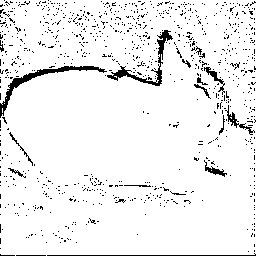

In [4]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

# Load the image
img = Image.open('E:/Senior Term1/New folder/cat.jpg')
# Preprocess the image
img = img.resize((256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:,:,:3], axis=0)
img_array = img_array / 255.

# Load the model
model = unet_model(input_shape=(256, 256, 3), num_classes=2)

# Make predictions
predictions = model.predict(img_array)

# Convert predictions to a numpy array and resize to original image size
predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)
predictions = Image.fromarray(np.uint8(predictions*255))
predictions = predictions.resize((img.width, img.height))

# Save the predicted image
predictions.save('predicted_image.jpg')
predictions
